# 05-Supervised learning 

In this notebook we will train a model based on the previous 4 notebooks. This include the use of two supervised classifiers named RandomForest and Gradient Boost. We will be using the library of scikitlearn to do this. However, there is no limitation in number of algorithms that can be used, since the notebook has been made modular for further easy implementations of other machine learning algorithms. 

## Table of contents

- Imports 
- Algorithms
- Dataset analysis
    - How do we evaluate the model?
    - Optimal hyperparameter search 
- Running the different algorithms
- Visualizing the cross-validated trained models
    - Interpreting important features used by the models
    - Precision and recall metrics
- Predicting solid-state qubit candidates
    - Save the summary and models

In [1]:
# Optional: Load the "autoreload" extension so that code can change
%load_ext autoreload

#OPTIONAL: Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Imports

In [2]:
import sys
sys.path.insert(0, "../")

from pathlib import Path
data_dir = Path.cwd().parent.parent / "data"
models_dir = Path.cwd().parent.parent / "models" 

print("Current data directory {}".format(data_dir))

Current data directory /home/oliver/Dokumenter/masterprosjekt/predicting-solid-state-qubit-candidates/data


In [3]:
from src.models import train_model, predict_model
from src.features import build_features
from src.visualization import visualize


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [4]:
#Standard libraries
import numpy as np
import pandas as pd
import pickle

#Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.neural_network import MLPClassifier

#Feature selections
from sklearn.model_selection import RepeatedStratifiedKFold

#metrics and nice visualization
from tqdm import tqdm

#visualizations
import plotly.graph_objs as go

# setting random seed for reproducibility
random_state=23462478

In [5]:
InsertApproach = "01-naive-approach"

In [6]:
trainingData   = pd.read_pickle(data_dir / InsertApproach / "processed" / "trainingData.pkl")
trainingTarget= pd.read_pickle(data_dir / InsertApproach / "processed" / "trainingTarget.pkl")
testSet       = pd.read_pickle(data_dir / InsertApproach / "processed" / "testSet.pkl")

trainingData

material_id  AtomicOrbitals|HOMO_character  AtomicOrbitals|HOMO_element  \
0           mp-7                            2.0                           16   
1          mp-14                            2.0                           34   
2          mp-19                            2.0                           52   
3          mp-24                            2.0                            6   
4          mp-47                            2.0                            6   
...          ...                            ...                          ...   
1613  mp-1205479                            2.0                            9   
1614  mp-1208643                            2.0                           16   
1615  mp-1210722                            2.0                            8   
1616  mp-1232407                            1.0                            1   
1617  mp-1238445                            2.0                            7   

      AtomicOrbitals|HOMO_energy  AtomicOrbitals|LUMO_character  \
0                      -0.261676                            2.0   
1                      -0.245806                            2.0   
2                      -0.226594                            2.0   
3                      -0.199186                            2.0   
4                      -0.199186                            2.0   
...                          ...                            ...   
1613                   -0.415606                            2.0   
1614                   -0.261676                            1.0   
1615                   -0.338381                            2.0   
1616                   -0.233471                            1.0   
1617                   -0.266297                            1.0   

      AtomicOrbitals|LUMO_element  AtomicOrbitals|LUMO_energy  \
0                              16                   -0.261676   
1                              34                   -0.245806   
2                              52                   -0.226594   
3                               6                   -0.199186   
4                               6                   -0.199186   
...                           ...                         ...   
1613                           51                   -0.185623   
1614                           72                   -0.166465   
1615                           52                   -0.226594   
1616                            1                   -0.233471   
1617                            1                   -0.233471   

      AtomicOrbitals|gap_AO  \
0                  0.000000   
1                  0.000000   
2                  0.000000   
3                  0.000000   
4                  0.000000   
...                     ...   
1613               0.229983   
1614               0.095211   
1615               0.111787   
1616               0.000000   
1617               0.032826   

      AtomicPackingEfficiency|mean simul. packing efficiency  \
0                                              0.023994        
1                                              0.023994        
2                                              0.023994        
3                                              0.023994        
4                                              0.023994        
...                                                 ...        
1613                                           0.000000        
1614                                          -0.033747        
1615                                          -0.007146        
1616                                           0.000000        
1617                                           0.000000        

      AtomicPackingEfficiency|mean abs simul. packing efficiency  ...  \
0                                              0.023994           ...   
1                                              0.023994           ...   
2                                              0.023994           ...   
3                       

# Algorithms
Below we define the algorithm to use and its abbreviation. Parameters that are optional to tune are the parameters to the algorithms, with the default value as their optimised value. Another parameter to tune is how many cross-validations one wants to iterate through for the analysis. In addition, one has to find the best features for a new algorithm which will be added further down in the notebook.

In [7]:
InsertAlgorithms    = [RandomForestClassifier    (random_state=random_state),\
                       GradientBoostingClassifier(random_state=random_state)]
InsertAbbreviations = ["RF", "GB"]
InsertprettyNames   = ["Random Forest", "Gradient Boost"]

# Dataset analysis


## How do we evaluate the model?

### Cross-validation

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it. 

### k-fold cross-validation

In k-fold cross-validation, the sample is partioned into k equal sized subsamples. Of the k samples, a single sample is used as validation set while the remaining k-1 samples are used as training data. The process is then repeated k-times, such that each of the k-th subsample is used as validation set exactly one time. Therefore, all observations are used for both training and validation, and each observation is used for validation exactly once. The k results from the folds can then be averaged to produce an estimate.

### Stratified k-fold cross-validation

In stratified k-fold cross validation, the fold that is selected contains roughly the same proportions of existing class labels. 

### n-repeated stratified k-fold cross-validation

In n-repeated stratified k-fold cross-validation, the stratified k-fold cross-validation is repeated n times, which yields n random partitions of the original sample. The n results can be averaged to produce a single estimation. 

## Sample size
To not discrimate a class, we make sure that each class is equally represented in the subsamples. Underneath shows a brief overview of the different methods involved to deal with this challenge.

### Random oversampling of minority class

Random oversampling can be achived by randomly duplicating examples from the minority class and adding them to the training dataset. 

The approach can be effective to algorithms that are vulnerable to a skewed dsitribution, however, it can also affect algorithms to overfit the minority class. 

### Random Undersampling of majority class

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. 

This can prove problematic, since the loss of data can make the decision boundary between minority and majority instances harder to learn. Additionally, there is a chance that the model might loose valuable information. 

### Both oversampling and undersampling

A third option might be to combine the two of them. 


## Optimal hyperparameters search

In this section we will find the optimal parameters used for the various algorithms. We will use imblearn's Pipeline and its implemented samplers, such as SMOTE and RandomUnderSampler. The advantage of using imblearn instead of sklearn, is that sklearn's pipeline will fit the samplers to the validation data as well, while imblearn only fit the resamplers to the training data. We store the best estimators and use them again under this section.

It is possible to have a large search over a wide amount of properties, but that is indeed extremely cpu-demanding. Therefore, we restrict ourself to the standard choice of some properties, but include a search for properties that can reduce the variance. 

In [8]:
numberRuns=10
numberSplits = 10

includeSampleMethods = ["", "under", "over", "both"]

Abbreviations = []
prettyNames   = []
Algorithms = []

rskfold = RepeatedStratifiedKFold(n_splits=numberSplits, n_repeats=numberRuns, random_state=random_state)

ModelsBestParams = pd.Series({}, dtype="string")

for i, algorithm in tqdm(enumerate(InsertAlgorithms)):
    for method in includeSampleMethods:
        print("Finding best params for: {}".format(InsertAbbreviations[i] + " " + method))
        bestEstimator, ModelsBestParams[InsertAbbreviations[i] + " " + method] = train_model.applyGridSearch(
                                                                             X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                                                                             y = trainingTarget.values.reshape(-1,),
                                                                        model = algorithm, 
                                                                           cv = rskfold, 
                                                                 sampleMethod = method)
        Abbreviations.append(InsertAbbreviations[i] + " " + method)
        prettyNames.append(InsertAbbreviations[i] + " " + method)
        Algorithms.append(bestEstimator)

0it [00:00, ?it/s]

Finding best params for: RF 
Fitting 100 folds for each of 96 candidates, totalling 9600 fits
Pipeline(steps=[('model',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        n_estimators=10,
                                        random_state=23462478))])
Finding best params for: RF under
Fitting 100 folds for each of 96 candidates, totalling 9600 fits
Pipeline(steps=[('underSampler',
                 RandomUnderSampler(sampling_strategy='majority')),
                ('model',
                 RandomForestClassifier(max_depth=5, random_state=23462478))])
Finding best params for: RF over
Fitting 100 folds for each of 96 candidates, totalling 9600 fits
Pipeline(steps=[('overSampler', SMOTE(sampling_strategy='minority')),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_features='sqrt', n_estimators=200,
                               

1it [2:05:16, 7516.23s/it]

Pipeline(steps=[('overSampler', SMOTE(sampling_strategy='minority')),
                ('underSampler',
                 RandomUnderSampler(sampling_strategy='majority')),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        random_state=23462478))])
Finding best params for: GB 
Fitting 100 folds for each of 128 candidates, totalling 12800 fits
Pipeline(steps=[('model',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt',
                                            n_estimators=200,
                                            random_state=23462478))])
Finding best params for: GB under
Fitting 100 folds for each of 128 candidates, totalling 12800 fits
Pipeline(steps=[('underSampler',
                 RandomUnderSampler(sampling_strategy='majority')),
                ('model',
                 GradientBoostingClassifier(criterion='mse', max_depth=2,
                                

2it [5:48:05, 10442.90s/it]

Pipeline(steps=[('overSampler', SMOTE(sampling_strategy='minority')),
                ('underSampler',
                 RandomUnderSampler(sampling_strategy='majority')),
                ('model',
                 GradientBoostingClassifier(max_depth=2, max_features='sqrt',
                                            n_estimators=150,
                                            random_state=23462478))])


In [9]:
pd.DataFrame(ModelsBestParams["RF "].cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.177895      0.032068         0.046145        0.010267   
1        0.326723      0.035293         0.040976        0.008035   
2        0.487095      0.027434         0.041278        0.002944   
3        0.872722      0.040982         0.053637        0.005342   
4        0.155598      0.022575         0.035403        0.005798   
..            ...           ...              ...             ...   
91       1.648511      0.024337         0.050625        0.003291   
92       0.138983      0.026595         0.036459        0.005440   
93       0.270108      0.018691         0.038735        0.006116   
94       0.420132      0.027668         0.042605        0.004899   
95       0.710546      0.015264         0.051244        0.004358   

   param_model__criterion param_model__max_depth param_model__max_features  \
0                    gini                      2                      auto   
1                    gini                      2                      auto   
2                    gini                      2                      auto   
3                    gini                      2                      auto   
4                    gini                      2                      sqrt   
..                    ...                    ...                       ...   
91                entropy                      5                      sqrt   
92                entropy                      5                      log2   
93                entropy                      5                      log2   
94                entropy                      5                      log2   
95                entropy                      5                      log2   

   param_model__n_estimators  \
0                         10   
1                         50   
2                        100   
3                        200   
4                         10   
..                       ...   
91                       200   
92                        10   
93                        50   
94                       100   
95                       200   

                                               params  split0_test_accuracy  \
0   {'model__criterion': 'gini', 'model__max_depth...              0.956790   
1   {'model__criterion': 'gini', 'model__max_depth...              0.956790   
2   {'model__criterion': 'gini', 'model__max_depth...              0.956790   
3   {'model__criterion': 'gini', 'model__max_depth...              0.956790   
4   {'model__criterion': 'gini', 'model__max_depth...              0.956790   
..                                                ...                   ...   
91  {'model__criterion': 'entropy', 'model__max_de...              0.981481   
92  {'model__criterion': 'entropy', 'model__max_de...              0.932099   
93  {'model__criterion': 'entropy', 'model__max_de...              0.944444   
94  {'model__criterion': 'entropy', 'model__max_de...              0.938272   
95  {'model__criterion': 'entropy', 'model__max_de...              0.944444   

    ...  split92_train_f1  split93_train_f1  split94_train_f1  \
0   ...          0.982366          0.978578          0.985332   
1   ...          0.978578          0.978997          0.980258   
2   ...          0.976486          0.978578          0.978997   
3   ...          0.979417          0.978578          0.980678   
4   ...          0.982366          0.978578          0.985332   
..  ...               ...               ...               ...   
91  ...          0.994774          0.993475          0.995207   
92  ...          0.963713          0.958054          0.970263   
93  ...          0.972329          0.969440          0.971501   
94  ...          0.969028          0.970263          0.969028   
95  ...          0.971501          0.974403          0.972329   

    split95_train_f1  split96_train_f1  split97_train_f1  split98_train_f1  \
0           0.976068          0.981100          0.982366 

# Running the different supervised models
Under follows the general model runSupervisedModel that takes the as parameter which model to run and returns nice statistics formatted as a dictionary.

In [11]:
SupervisedModels = pd.Series({}, dtype="string")

In [12]:
for i, algorithm in enumerate(Algorithms): 
    print("Current training algorithm: {}".format(prettyNames[i]))
    SupervisedModels[Abbreviations[i]] = (
        train_model.runSupervisedModel(classifier  = algorithm, 
                                     X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                                     y = trainingTarget.values.reshape(-1,),
                                     k = numberSplits,
                                     n = numberRuns,
                      resamplingMethod = "under",
                     featureImportance = True)
    )

0it [00:00, ?it/s]

Current training algorithm: RF 


100it [00:26,  3.79it/s]
0it [00:00, ?it/s]

Mean accuracy:0.9855379188712523
Standard deviation:0.009095689232724287
Current training algorithm: RF under


100it [02:04,  1.24s/it]
0it [00:00, ?it/s]

Mean accuracy:0.9978977839122769
Standard deviation:0.003834564245124693
Current training algorithm: RF over


100it [05:23,  3.24s/it]
0it [00:00, ?it/s]

Mean accuracy:0.9961045932060424
Standard deviation:0.004764021977542579
Current training algorithm: RF both


100it [05:38,  3.38s/it]
0it [00:00, ?it/s]

Mean accuracy:0.9963530404110115
Standard deviation:0.004793657665199207
Current training algorithm: GB 


100it [03:40,  2.21s/it]
0it [00:00, ?it/s]

Mean accuracy:0.9993823326432023
Standard deviation:0.0018530056402798927
Current training algorithm: GB under


100it [01:53,  1.13s/it]
0it [00:00, ?it/s]

Mean accuracy:0.9993811824246608
Standard deviation:0.0018564622280055408
Current training algorithm: GB over


100it [02:48,  1.69s/it]
0it [00:00, ?it/s]

Mean accuracy:0.999690974618511
Standard deviation:0.0013470147741245192
Current training algorithm: GB both


100it [03:33,  2.14s/it]

Mean accuracy:0.9996292462234492
Standard deviation:0.0014674898980835231


# Visualizing the cross-validated trained models

In [13]:
visualize.plot_accuracy(SupervisedModels, prettyNames)

The standard deviation is calculated as a function difference of the $100$ models in the purpose of visalizing how much the models deviate from each other.

## Interpreting important features used by the models

Which features are the most important in predicting to give a label $0$ or $1$?

In [14]:
"""
def plot_important_features(models, names):
    fig = go.Figure( 
            layout = go.Layout (
                title=go.layout.Title(text='Features used in model (Nruns = {})'.format(numberRuns*numberSplits)),
                yaxis=dict(title="Number times"),
                barmode='group'
            )
        )

    for i, model in enumerate(models):
        fig.add_traces(go.Bar(name=names[i], x=trainingData.columns.values, y=model['importantKeys']))

    fig.show()

    fig = go.Figure( 
            layout = go.Layout (
                title=go.layout.Title(text="Feature Importance for the 100th iteration".format(numberRuns*numberSplits)),
                yaxis=dict(title='Relative importance'),
                barmode='group'
            )
        )

    for i, model in enumerate(models):
        fig.add_traces(go.Bar(name=names[i], x=trainingData.columns.values, y=model['relativeImportance']))

    fig.show()
"""
#visualize.plot_important_features(SupervisedModels, prettyNames, 
#                        X=trainingData.drop(["material_id", "full_formula"], axis=1),
#                       k = numberSplits, n = numberRuns)

'\ndef plot_important_features(models, names):\n    fig = go.Figure( \n            layout = go.Layout (\n                title=go.layout.Title(text=\'Features used in model (Nruns = {})\'.format(numberRuns*numberSplits)),\n                yaxis=dict(title="Number times"),\n                barmode=\'group\'\n            )\n        )\n\n    for i, model in enumerate(models):\n        fig.add_traces(go.Bar(name=names[i], x=trainingData.columns.values, y=model[\'importantKeys\']))\n\n    fig.show()\n\n    fig = go.Figure( \n            layout = go.Layout (\n                title=go.layout.Title(text="Feature Importance for the 100th iteration".format(numberRuns*numberSplits)),\n                yaxis=dict(title=\'Relative importance\'),\n                barmode=\'group\'\n            )\n        )\n\n    for i, model in enumerate(models):\n        fig.add_traces(go.Bar(name=names[i], x=trainingData.columns.values, y=model[\'relativeImportance\']))\n\n    fig.show()\n'

In [15]:
visualize.plot_important_features_restricted_domain(SupervisedModels, prettyNames, trainingData, k = numberSplits, n = numberRuns)

## Precision and recall metrics

In [16]:
def plot_confusion_metrics(models, names, data, abbreviations=[]):
    fig = go.Figure( 
            layout = go.Layout (
                title=go.layout.Title(text="False positives (Nruns = {})".format(numberRuns*numberSplits)),
                yaxis=dict(title='Counts'),
                barmode='group'
            )
        )

    for i, model in enumerate(models):

        fig.add_traces(go.Bar(name=names[i], 
                            x=data['full_formula'][model['falsePositives'] > 0],
                            y=model['falsePositives'][model['falsePositives'] > 0]))

    fig.show()

    fig = go.Figure( 
            layout = go.Layout (
                title=go.layout.Title(text="False negatives (Nruns = {})".format(numberRuns*numberSplits)),
                yaxis=dict(title='Counts'),
                barmode='group'
            )
        )
    for i, model in enumerate(models):
        fig.add_traces(go.Bar(name=names[i], 
                                x=data['full_formula'][model['falseNegatives'] > 0],
                                y=model['falseNegatives'][model['falseNegatives'] > 0]))

    fig.show()
plot_confusion_metrics(SupervisedModels, prettyNames, trainingData)

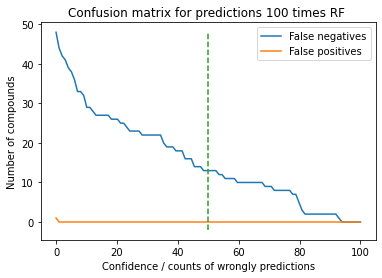

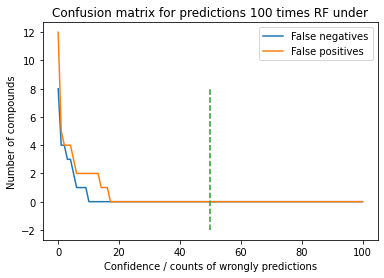

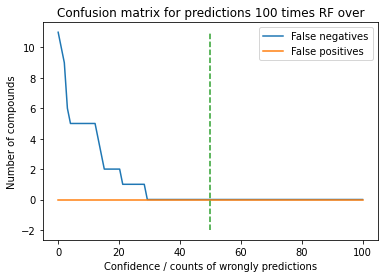

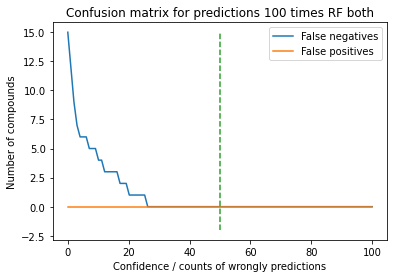

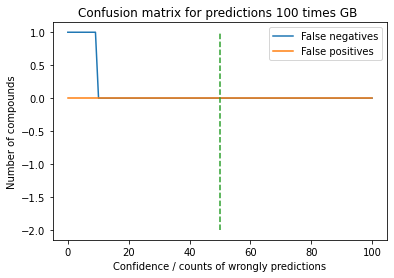

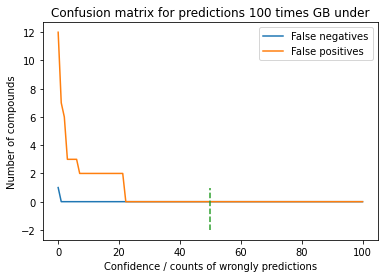

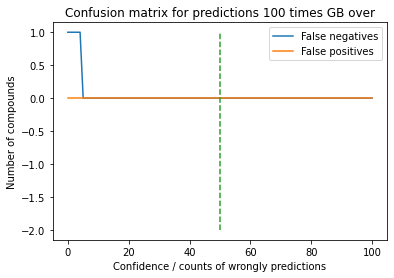

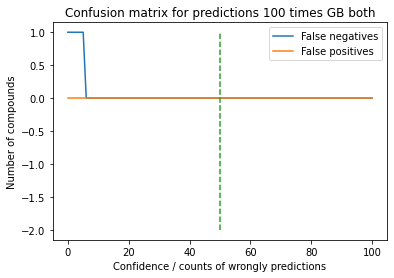

In [17]:
visualize.plot_confusion_matrixQT(SupervisedModels, trainingTarget, trainingData, names=prettyNames, k = numberSplits, n = numberRuns)

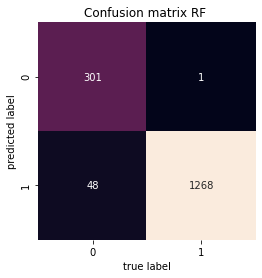

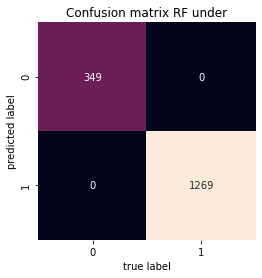

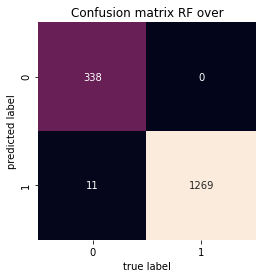

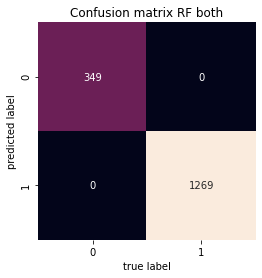

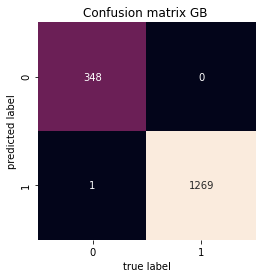

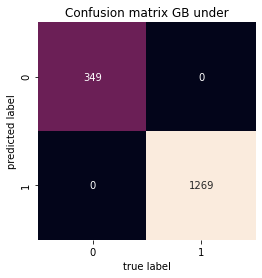

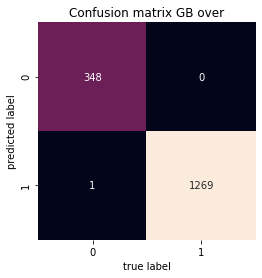

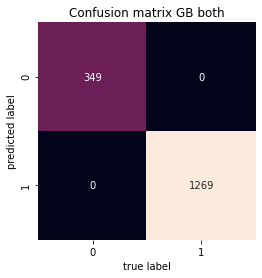

In [18]:
visualize.confusion_matrixQT(SupervisedModels, trainingTarget, prettyNames)

# Predicting solid-state qubit candidates

It is time to make the prediction based on the best estimators and features possible. We have chosen to choose the features that have been deemed important by sklearn at least 50 percent of the cross validation runs as important. 

In [21]:
Summary                 = pd.DataFrame({}, dtype="string")
Summary["material_id"]  = testSet["material_id"]
Summary["full_formula"] = testSet["full_formula"]
Summary["pretty_formula"] = testSet["pretty_formula"]

PredictedCandidates = pd.Series({}, dtype="string")

threshold = numberSplits*numberRuns/2 #50% when equal
trainSet = trainingData.drop(["material_id", "full_formula"], axis=1)
testData = testSet.drop(["pretty_formula", "candidate", "full_formula", "material_id"], axis=1)
fittedAlgorithms = [] 

for i, algorithm in tqdm(enumerate(Algorithms)):
    
    fittedAlgorithm = train_model.fitAlgorithm(algorithm, 
                                    trainingData   = trainSet[trainSet.columns[SupervisedModels[Abbreviations[i]]["importantKeys"]>threshold]],\
                                    trainingTarget = trainingTarget.values.reshape(-1,),)
    
    fittedAlgorithms.append(fittedAlgorithm)
    
    PredictedCandidates[Abbreviations[i]],\
    PredictedCandidates[Abbreviations[i]+"Prob"] = predict_model.runPredictions(fittedAlgorithm,\
                                                        testData = testData[testData.columns[SupervisedModels[Abbreviations[i]]["importantKeys"]>threshold]])

8it [00:05,  1.35it/s]


In [22]:
for abbreviation in Abbreviations:
    Summary[abbreviation]            = PredictedCandidates[abbreviation]
    Summary[abbreviation + "Prob"]       = PredictedCandidates[abbreviation + "Prob"]
    print("{} predict the number of candidates as: {}".format(abbreviation, int(np.sum(PredictedCandidates[abbreviation]))))

RF  predict the number of candidates as: 11946
RF under predict the number of candidates as: 14229
RF over predict the number of candidates as: 14054
RF both predict the number of candidates as: 14251
GB  predict the number of candidates as: 11749
GB under predict the number of candidates as: 14006
GB over predict the number of candidates as: 14566
GB both predict the number of candidates as: 14314


In [23]:
Summary

material_id full_formula pretty_formula  RF    RF Prob  RF under  \
1618    mvc-12905        Fe4O8           FeO2  1.0  1.000000       1.0   
1619        mp-25           N8             N2  1.0  0.698718       1.0   
1620       mp-111          Ne1             Ne  0.0  0.000000       0.0   
1621       mp-118          P24              P  1.0  0.600000       1.0   
1622       mp-154           N8             N2  1.0  0.598718       1.0   
...           ...          ...            ...  ...       ...       ...   
25207  mp-1539137     Rb1Cr5S8        RbCr5S8  1.0  0.900000       1.0   
25208  mp-1541522      Bi2P2O8          BiPO4  1.0  0.900000       1.0   
25209  mp-1541714    Cs3As2Cl9      Cs3As2Cl9  0.0  0.000000       0.0   
25210  mp-1542038    Cs2Sn2Se6        CsSnSe3  1.0  0.900000       1.0   
25211  mp-1542939   Ba1Mo1P2O8     BaMo(PO4)2  1.0  0.900000       1.0   

       RF underProb  RF over  RF overProb  RF both  RF bothProb  GB   \
1618       0.995251      1.0     0.998867      1.0     0.998697  1.0   
1619       0.655580      1.0     0.526842      1.0     0.610287  0.0   
1620       0.230000      0.0     0.356774      0.0     0.349123  0.0   
1621       0.598786      1.0     0.596777      1.0     0.603682  0.0   
1622       0.542401      0.0     0.478481      1.0     0.531997  0.0   
...             ...      ...          ...      ...          ...  ...   
25207      0.717509      1.0     0.796707      1.0     0.721820  1.0   
25208      0.947087      1.0     0.906913      1.0     0.901247  1.0   
25209      0.190000      0.0     0.145088      0.0     0.170636  0.0   
25210      0.838496      1.0     0.871183      1.0     0.820124  1.0   
25211      0.968457      1.0     0.917637      1.0     0.891042  1.0   

        GB Prob  GB under  GB underProb  GB over  GB overProb  GB both  \
1618   1.000000       1.0      0.999675      1.0     0.999618      1.0   
1619   0.125005       1.0      0.505704      1.0     0.506616      1.0   
1620   0.000263       0.0      0.072699      0.0     0.318225      0.0   
1621   0.163902       0.0      0.174521      0.0     0.132123      0.0   
1622   0.005044       0.0      0.088415      0.0     0.076138      0.0   
...         ...       ...           ...      ...          ...      ...   
25207  0.999609       1.0      0.971846      1.0     0.958785      1.0   
25208  0.999998       1.0      0.997928      1.0     0.998351      1.0   
25209  0.000014       0.0      0.009126      0.0     0.007790      0.0   
25210  0.999940       1.0      0.994771      1.0     0.992499      1.0   
25211  0.999999       1.0      0.998763      1.0     0.998129      1.0   

       GB bothProb  
1618      0.999690  
1619      0.588456  
1620      0.253687  
1621      0.195004  
1622      0.097681  
...            ...  
25207     0.970737  
25208     0.998496  
25209     0.004975  
25210     0.996654  
25211     0.998487  

[23594 rows x 19 columns]

## Save the summary and models

In [24]:
for i, fitted_algorithm in tqdm(enumerate(fittedAlgorithms)):
    file_path = Path(models_dir / InsertApproach / "trained-models" / Path(prettyNames[i] + ".pkl"))
    with file_path.open("wb") as fp:
        pickle.dump(fitted_algorithm, fp)
        

Summary.to_pickle(models_dir / InsertApproach / "summary" / "summary.pkl")

8it [00:00, 229.49it/s]


In [48]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score, make_scorer

scoring = {'accuracy':  make_scorer(accuracy_score),
               'precision': make_scorer(precision_score),
               'recall':    make_scorer(recall_score),
               'f1':        make_scorer(f1_score)}

In [84]:
for i in range(8):
    print(ModelsBestParams[i].best_estimator_.named_steps["model"].feature_importances_.shape)

(29,)
(199,)
(272,)
(263,)
(113,)
(108,)
(108,)
(108,)


In [ ]:
get_feature_df(ModelsBestParams[0],list(trainingData.columns))

In [76]:
#print("Optimal number of features : %d" % rfecv.n_features_)
features=list(trainingData.columns[ModelsBestParams[0].best_estimator_.named_steps["model"].support_])
print(features)

AttributeError: 'RandomForestClassifier' object has no attribute 'support_'

In [41]:
results = ModelsBestParams[0].cv_results_ 

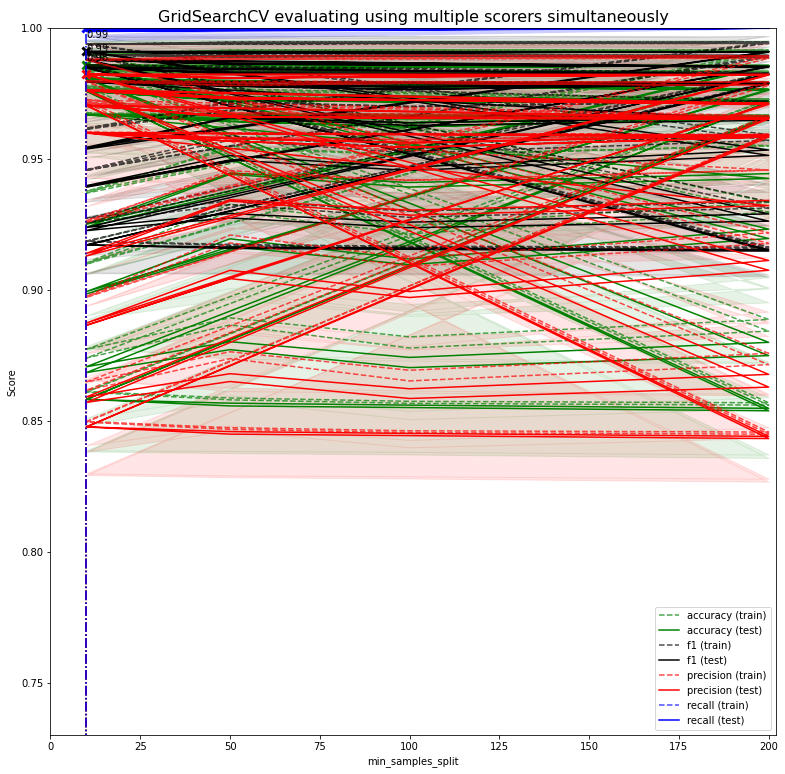

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 202)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_model__n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k', 'r', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [70]:
#results.keys()